In [1]:
import matplotlib as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np
import pandas as pd

from sat_metropolis import models, utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
south_head = pd.read_csv("south_head.csv")
south_head

,,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,35-39 years,40-44 years,45-49 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85-89 years,90 years and over
0,Male,3,6,6,12,9,3,9,9,6,6,15,6,3,6,3,3,0,0,0
1,Female,6,0,3,6,3,6,3,9,3,6,9,6,9,3,3,3,0,0,0
2,Total,15,3,12,15,15,12,9,18,9,12,21,12,12,12,6,0,0,0,0


In [3]:
(s, num_vars) = models.get_nz_stats_smt(path_to_dataset='south_head.csv')

In [4]:
# get one sample for initial state for the experiment providing an initial state
s.check()
m = s.model()
init_state = [v.as_long() for (k,v) in sorted([(int(str(v).replace('x','')), m[v]) for v in m], key=lambda x: x[0])]
print(init_state)

[5, 4, 8, 10, 11, 2, 7, 7, 4, 6, 13, 6, 3, 8, 1, 1, 0, 0, 0, 8, 0, 2, 4, 2, 8, 1, 9, 3, 4, 7, 4, 7, 2, 3, 1, 0, 0, 0]


In [5]:
with pm.Model() as model_dirac:
    numpy_data = south_head.to_numpy()[:,1:]
    num_vars = 19*2

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)
    
    for i in range(19):
        pm.DiracDelta(f'obs_male_{i}_1', pt.tensor.le(x[i], numpy_data[0,i]+2), observed=True)
        if(numpy_data[0,i]>0):
            pm.DiracDelta(f'obs_male_{i}_2', pt.tensor.le(numpy_data[0,i]-2,x[i]), observed=True)
                
        pm.DiracDelta(f'obs_female_{i+19}_1', pt.tensor.le(x[i+19], numpy_data[1,i]+2), observed=True)
        if(numpy_data[1,i]>0):
            pm.DiracDelta(f'obs_female_{i+19}_2', pt.tensor.le(numpy_data[1,i]-2,x[i+19]), observed=True)
            
        pm.DiracDelta(f'obs_total_{i}_1', pt.tensor.le(x[i+19] + x[i], numpy_data[2,i]+2), observed=True)
        if(numpy_data[2,i]>0):
            pm.DiracDelta(f'obs_total_{i}_2', pt.tensor.le(numpy_data[2,i]-2, x[i+19] + x[i]), observed=True)

**Regular Metropolis crahses because it cannot find a satisfying initial state**


In [6]:
with model_dirac:
    trace = pm.sample(
        draws=10_000,
        tune=1000,
        chains=4,        
    ) 

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'x': array([62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62])}

Logp initial evaluation results:
{'x': -183.78, 'obs_male_0_1': -inf, 'obs_male_0_2': 0.0, 'obs_female_19_1': -inf, 'obs_female_19_2': 0.0, 'obs_total_0_1': -inf, 'obs_total_0_2': 0.0, 'obs_male_1_1': -inf, 'obs_male_1_2': 0.0, 'obs_female_20_1': -inf, 'obs_total_1_1': -inf, 'obs_total_1_2': 0.0, 'obs_male_2_1': -inf, 'obs_male_2_2': 0.0, 'obs_female_21_1': -inf, 'obs_female_21_2': 0.0, 'obs_total_2_1': -inf, 'obs_total_2_2': 0.0, 'obs_male_3_1': -inf, 'obs_male_3_2': 0.0, 'obs_female_22_1': -inf, 'obs_female_22_2': 0.0, 'obs_total_3_1': -inf, 'obs_total_3_2': 0.0, 'obs_male_4_1': -inf, 'obs_male_4_2': 0.0, 'obs_female_23_1': -inf, 'obs_female_23_2': 0.0, 'obs_total_4_1': -inf, 'obs_total_4_2': 0.0, 'obs_male_5_1': -inf, 'obs_male_5_2': 0.0, 'obs_female_24_1': -inf, 'obs_female_24_2': 0.0, 'obs_total_5_1': -inf, 'obs_total_5_2': 0.0, 'obs_male_6_1': -inf, 'obs_male_6_2': 0.0, 'obs_female_25_1': -inf, 'obs_female_25_2': 0.0, 'obs_total_6_1': -inf, 'obs_total_6_2': 0.0, 'obs_male_7_1': -inf, 'obs_male_7_2': 0.0, 'obs_female_26_1': -inf, 'obs_female_26_2': 0.0, 'obs_total_7_1': -inf, 'obs_total_7_2': 0.0, 'obs_male_8_1': -inf, 'obs_male_8_2': 0.0, 'obs_female_27_1': -inf, 'obs_female_27_2': 0.0, 'obs_total_8_1': -inf, 'obs_total_8_2': 0.0, 'obs_male_9_1': -inf, 'obs_male_9_2': 0.0, 'obs_female_28_1': -inf, 'obs_female_28_2': 0.0, 'obs_total_9_1': -inf, 'obs_total_9_2': 0.0, 'obs_male_10_1': -inf, 'obs_male_10_2': 0.0, 'obs_female_29_1': -inf, 'obs_female_29_2': 0.0, 'obs_total_10_1': -inf, 'obs_total_10_2': 0.0, 'obs_male_11_1': -inf, 'obs_male_11_2': 0.0, 'obs_female_30_1': -inf, 'obs_female_30_2': 0.0, 'obs_total_11_1': -inf, 'obs_total_11_2': 0.0, 'obs_male_12_1': -inf, 'obs_male_12_2': 0.0, 'obs_female_31_1': -inf, 'obs_female_31_2': 0.0, 'obs_total_12_1': -inf, 'obs_total_12_2': 0.0, 'obs_male_13_1': -inf, 'obs_male_13_2': 0.0, 'obs_female_32_1': -inf, 'obs_female_32_2': 0.0, 'obs_total_13_1': -inf, 'obs_total_13_2': 0.0, 'obs_male_14_1': -inf, 'obs_male_14_2': 0.0, 'obs_female_33_1': -inf, 'obs_female_33_2': 0.0, 'obs_total_14_1': -inf, 'obs_total_14_2': 0.0, 'obs_male_15_1': -inf, 'obs_male_15_2': 0.0, 'obs_female_34_1': -inf, 'obs_female_34_2': 0.0, 'obs_total_15_1': -inf, 'obs_male_16_1': -inf, 'obs_female_35_1': -inf, 'obs_total_16_1': -inf, 'obs_male_17_1': -inf, 'obs_female_36_1': -inf, 'obs_total_17_1': -inf, 'obs_male_18_1': -inf, 'obs_female_37_1': -inf, 'obs_total_18_1': -inf}
You can call `model.debug()` for more details.

**If we manually provide a satisfying initial state, then it can sample.**

The reason is that all non-zero probability are not separated by zero-probability regions. Thus, when the sampler lands in a non-zero probabilty state it can explore the region effectively.

Nevertheless, having to provide an initial state is a difficult task. In fact, here we use the samplers in sat-metropolis to find the initial state. Thus, we do not consider that standard metropolis can be effectively applied in this case.

In [7]:
# sampling
with model_dirac:
    trace = pm.sample(
        draws=10_000,
        tune=1000,
        chains=4,
        initvals={'x': init_state}
    ) 

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x]


/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


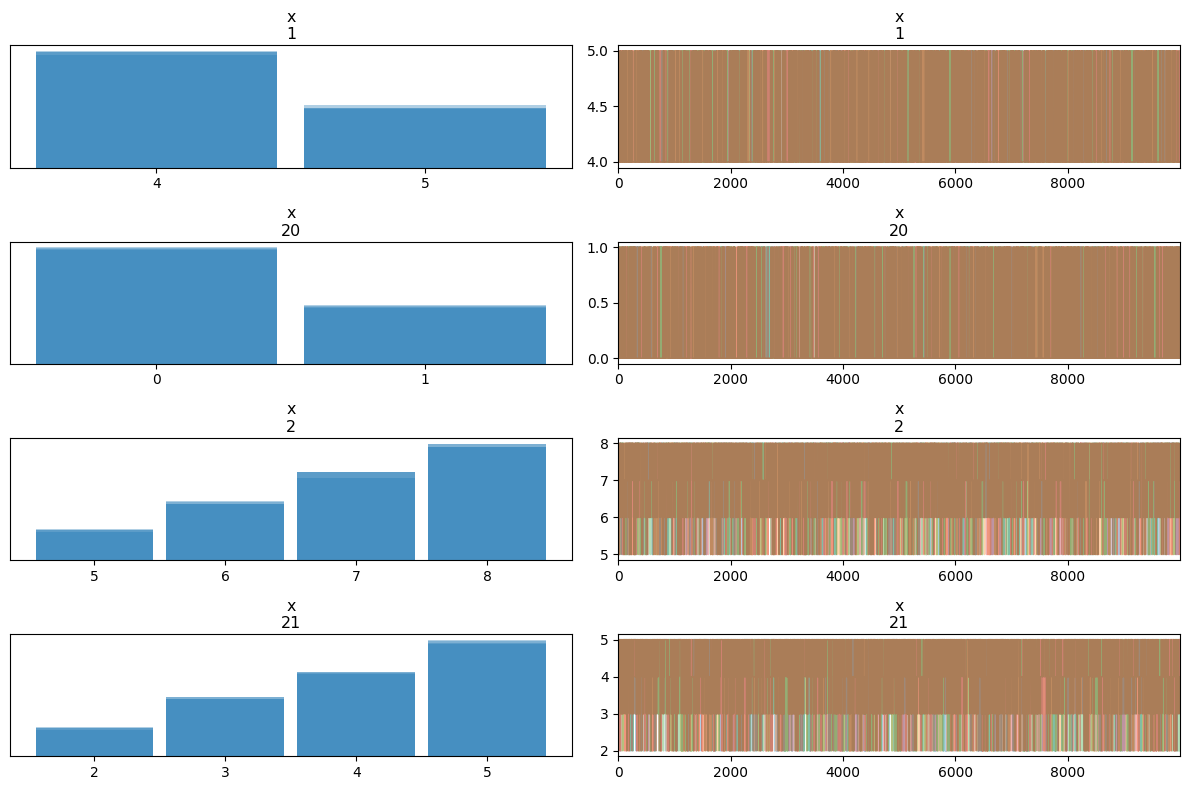

In [8]:
pm.plot_trace(trace, var_names=['x'], coords={'x_dim_0': [1, 20, 2, 21]}, combined=False, compact=False);
plt.pyplot.savefig('plot_pymc.png',dpi=150);

In [9]:
pm.summary(trace)

/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],5.000,0.000,5.0,5.0,0.000,NaN,40000.0,40000.0,NaN
x[1],4.342,0.475,4.0,5.0,0.006,0.002,6415.0,6415.0,1.0
x[2],6.991,1.006,5.0,8.0,0.013,0.006,5699.0,7510.0,1.0
x[3],11.008,1.001,10.0,13.0,0.013,0.006,6118.0,6767.0,1.0
x[4],10.006,0.999,8.0,11.0,0.013,0.006,5926.0,8582.0,1.0
x[5],4.007,0.996,2.0,5.0,0.013,0.006,6176.0,7999.0,1.0
x[6],7.995,0.996,7.0,10.0,0.013,0.006,6019.0,6592.0,1.0
x[7],8.986,1.293,7.0,11.0,0.017,0.006,5885.0,7880.0,1.0
x[8],6.012,1.303,4.0,8.0,0.018,0.006,5144.0,7430.0,1.0
x[9],6.000,1.287,4.0,8.0,0.017,0.006,5993.0,7837.0,1.0


In [10]:
utils.save_trace(trace, f'nz_db_pymc_{num_vars}.nc')